# Federated Learning Evaluation Notebook

This notebook provides comprehensive evaluation and visualization of federated learning experiments for predictive maintenance.

## Contents
1. Setup and Data Loading
2. Run Federated Experiment
3. Training Curves Visualization
4. Client Contribution Analysis
5. Baseline Comparison
6. Privacy Analysis
7. Summary and Export

In [1]:
# Setup: Install dependencies if needed
import sys
sys.path.insert(0, '..')

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pathlib import Path

# Project imports
from src.utils import (
    set_seed, make_reproducible,
    ExperimentLogger, create_experiment_logger,
    ConfigManager, save_config
)
from src.models.tcn import RULPredictor, compute_rul_metrics
from src.clients.client import SimulatedClientTrainer
from src.server.aggregator import FedAvgAggregator

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print('Setup complete!')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

Setup complete!
PyTorch version: 2.8.0+cpu
CUDA available: False


## 1. Configuration

In [2]:
# Experiment configuration
CONFIG = {
    'experiment_name': 'federated_rul_evaluation',
    'seed': 42,
    
    # Federated settings
    'num_clients': 5,
    'num_rounds': 15,
    'clients_per_round': 3,
    
    # Model settings
    'input_channels': 14,
    'sequence_length': 50,
    'hidden_channels': 32,
    'num_levels': 3,
    
    # Training settings
    'local_epochs': 3,
    'batch_size': 32,
    'learning_rate': 0.001,
    
    # Data settings
    'samples_per_client': 500,
    'val_split': 0.2,
}

# Set reproducibility
make_reproducible(CONFIG['seed'])
print('Configuration:')
for k, v in CONFIG.items():
    print(f'  {k}: {v}')

Configuration:
  experiment_name: federated_rul_evaluation
  seed: 42
  num_clients: 5
  num_rounds: 15
  clients_per_round: 3
  input_channels: 14
  sequence_length: 50
  hidden_channels: 32
  num_levels: 3
  local_epochs: 3
  batch_size: 32
  learning_rate: 0.001
  samples_per_client: 500
  val_split: 0.2


## 2. Generate Synthetic Data

For demonstration, we generate synthetic sensor data simulating industrial equipment degradation.

In [3]:
def generate_synthetic_client_data(client_id, num_samples, seq_length, num_features, seed=None):
    """Generate synthetic RUL data for a client."""
    if seed is not None:
        np.random.seed(seed + client_id)
    
    # Generate sequences with degradation patterns
    X = []
    y = []
    
    for i in range(num_samples):
        # RUL decreases from max_rul to 0
        max_rul = np.random.randint(80, 150)
        current_rul = np.random.randint(0, max_rul)
        
        # Degradation factor (higher = more degraded)
        degradation = 1 - (current_rul / max_rul)
        
        # Generate sensor readings with degradation influence
        base_signal = np.random.randn(seq_length, num_features) * 0.5
        degradation_signal = degradation * np.random.randn(seq_length, num_features) * 2
        noise = np.random.randn(seq_length, num_features) * 0.1
        
        # Client-specific bias (heterogeneity)
        client_bias = (client_id - 2) * 0.1
        
        sequence = base_signal + degradation_signal + noise + client_bias
        X.append(sequence)
        y.append(current_rul)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Generate data for each client
client_data = {}
for c in range(CONFIG['num_clients']):
    X, y = generate_synthetic_client_data(
        client_id=c,
        num_samples=CONFIG['samples_per_client'],
        seq_length=CONFIG['sequence_length'],
        num_features=CONFIG['input_channels'],
        seed=CONFIG['seed']
    )
    client_data[c] = {'X': X, 'y': y}
    print(f'Client {c}: X shape = {X.shape}, y range = [{y.min():.0f}, {y.max():.0f}]')

print(f'\nTotal samples: {sum(d["X"].shape[0] for d in client_data.values())}')

Client 0: X shape = (500, 50, 14), y range = [0, 145]
Client 1: X shape = (500, 50, 14), y range = [0, 142]
Client 2: X shape = (500, 50, 14), y range = [0, 146]
Client 3: X shape = (500, 50, 14), y range = [0, 145]
Client 4: X shape = (500, 50, 14), y range = [0, 143]

Total samples: 2500


## 3. Run Federated Learning Experiment

In [4]:
# Initialize global model
global_model = RULPredictor(
    num_channels=CONFIG['input_channels'],
    hidden=CONFIG['hidden_channels'],
    num_layers=CONFIG['num_levels'],
)

# Initialize aggregator
aggregator = FedAvgAggregator()

# Storage for metrics
round_metrics = []
client_round_metrics = []

print(f'Model parameters: {sum(p.numel() for p in global_model.parameters()):,}')
print(f'Starting {CONFIG["num_rounds"]} rounds of federated training...')
print()

Model parameters: 18,849
Starting 15 rounds of federated training...



In [5]:
# Federated training loop
import copy
import random

for round_id in range(1, CONFIG['num_rounds'] + 1):
    # Reset aggregator for new round
    aggregator.reset(round_id)
    
    # Select clients for this round
    selected_clients = random.sample(
        range(CONFIG['num_clients']), 
        CONFIG['clients_per_round']
    )
    
    round_client_metrics = []
    
    for client_id in selected_clients:
        # Get client data
        X, y = client_data[client_id]['X'], client_data[client_id]['y']
        
        # Split into train/val
        n_val = int(len(X) * CONFIG['val_split'])
        X_train, X_val = X[:-n_val], X[-n_val:]
        y_train, y_val = y[:-n_val], y[-n_val:]
        
        # Create local model copy
        local_model = copy.deepcopy(global_model)
        optimizer = torch.optim.Adam(local_model.parameters(), lr=CONFIG['learning_rate'])
        loss_fn = torch.nn.MSELoss()
        
        # Convert to tensors (model expects (N, W, C), transposes internally)
        X_train_t = torch.tensor(X_train)
        y_train_t = torch.tensor(y_train)
        X_val_t = torch.tensor(X_val)
        y_val_t = torch.tensor(y_val)
        
        # Local training
        local_model.train()
        train_losses = []
        
        for epoch in range(CONFIG['local_epochs']):
            # Mini-batch training
            indices = torch.randperm(len(X_train_t))
            for i in range(0, len(indices), CONFIG['batch_size']):
                batch_idx = indices[i:i+CONFIG['batch_size']]
                X_batch = X_train_t[batch_idx]
                y_batch = y_train_t[batch_idx]
                
                optimizer.zero_grad()
                pred = local_model(X_batch).squeeze()
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
        
        # Validation
        local_model.eval()
        with torch.no_grad():
            val_pred = local_model(X_val_t).squeeze()
            val_loss = loss_fn(val_pred, y_val_t).item()
            val_mae = torch.mean(torch.abs(val_pred - y_val_t)).item()
        
        # Compute delta and submit to aggregator
        delta = {k: local_model.state_dict()[k] - global_model.state_dict()[k] 
                 for k in global_model.state_dict()}
        aggregator.add_update(client_id=str(client_id), delta=delta, num_samples=len(X_train))
        
        round_client_metrics.append({
            'client_id': client_id,
            'round_id': round_id,
            'train_loss': np.mean(train_losses),
            'val_loss': val_loss,
            'val_mae': val_mae,
            'num_samples': len(X_train),
        })
    
    # Aggregate and apply updates
    aggregator.aggregate_and_apply(global_model)
    
    # Evaluate global model on all data
    global_model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for c in range(CONFIG['num_clients']):
            X, y = client_data[c]['X'], client_data[c]['y']
            X_t = torch.tensor(X)  # No permute - model handles it internally
            pred = global_model(X_t).squeeze().numpy()
            all_preds.extend(pred)
            all_targets.extend(y)
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    global_mae = np.mean(np.abs(all_preds - all_targets))
    global_rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))
    
    # Store metrics
    round_metrics.append({
        'round_id': round_id,
        'global_mae': global_mae,
        'global_rmse': global_rmse,
        'avg_client_loss': np.mean([m['val_loss'] for m in round_client_metrics]),
        'participants': selected_clients,
    })
    client_round_metrics.extend(round_client_metrics)
    
    print(f'Round {round_id:2d}: MAE={global_mae:.2f}, RMSE={global_rmse:.2f}, Clients={selected_clients}')

print('\nTraining complete!')

Round  1: MAE=49.44, RMSE=60.34, Clients=[0, 4, 2]
Round  2: MAE=43.51, RMSE=54.28, Clients=[2, 1, 0]
Round  3: MAE=37.33, RMSE=46.73, Clients=[1, 0, 2]
Round  4: MAE=32.75, RMSE=39.90, Clients=[4, 0, 2]
Round  5: MAE=31.01, RMSE=36.75, Clients=[3, 0, 4]
Round  6: MAE=30.22, RMSE=35.77, Clients=[0, 1, 4]
Round  7: MAE=26.33, RMSE=31.71, Clients=[4, 0, 2]
Round  8: MAE=17.69, RMSE=22.27, Clients=[1, 3, 0]
Round  9: MAE=13.08, RMSE=16.39, Clients=[3, 2, 0]
Round 10: MAE=11.32, RMSE=14.36, Clients=[1, 3, 4]
Round 11: MAE=11.05, RMSE=13.98, Clients=[2, 1, 0]
Round 12: MAE=10.51, RMSE=13.39, Clients=[2, 0, 3]
Round 13: MAE=10.53, RMSE=13.43, Clients=[3, 0, 1]
Round 14: MAE=10.22, RMSE=13.07, Clients=[2, 4, 0]
Round 15: MAE=9.72, RMSE=12.61, Clients=[3, 0, 1]

Training complete!


## 4. Training Curves Visualization

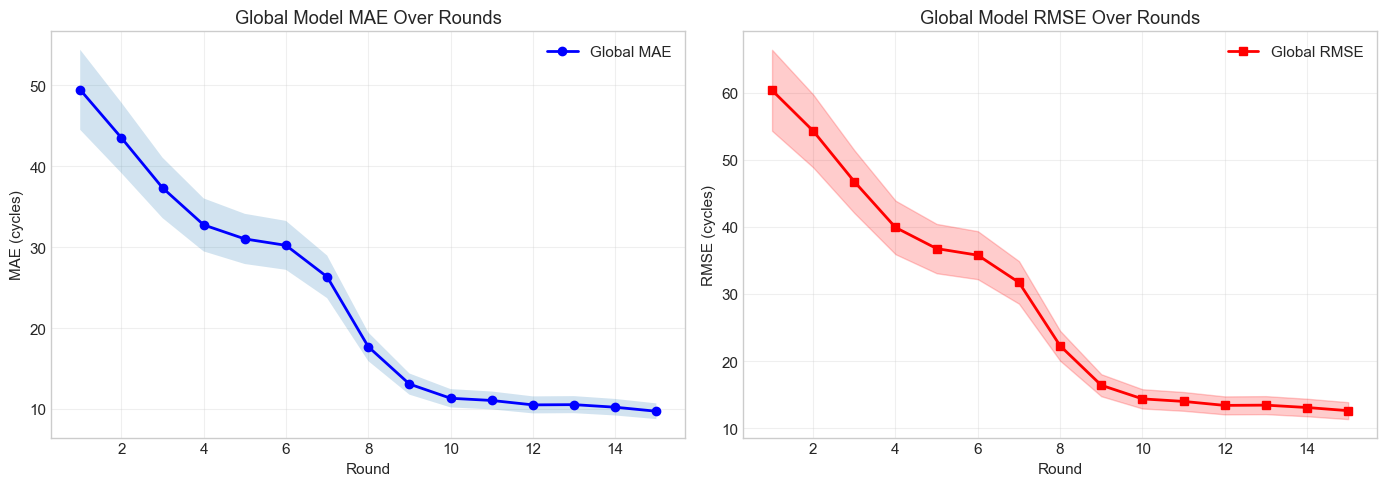

Best MAE: 9.72 at round 15
Best RMSE: 12.61 at round 15


In [6]:
# Convert to DataFrames
df_rounds = pd.DataFrame(round_metrics)
df_clients = pd.DataFrame(client_round_metrics)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE over rounds
ax1 = axes[0]
ax1.plot(df_rounds['round_id'], df_rounds['global_mae'], 'b-o', linewidth=2, markersize=6, label='Global MAE')
ax1.fill_between(df_rounds['round_id'], df_rounds['global_mae'] * 0.9, df_rounds['global_mae'] * 1.1, alpha=0.2)
ax1.set_xlabel('Round')
ax1.set_ylabel('MAE (cycles)')
ax1.set_title('Global Model MAE Over Rounds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RMSE over rounds
ax2 = axes[1]
ax2.plot(df_rounds['round_id'], df_rounds['global_rmse'], 'r-s', linewidth=2, markersize=6, label='Global RMSE')
ax2.fill_between(df_rounds['round_id'], df_rounds['global_rmse'] * 0.9, df_rounds['global_rmse'] * 1.1, alpha=0.2, color='red')
ax2.set_xlabel('Round')
ax2.set_ylabel('RMSE (cycles)')
ax2.set_title('Global Model RMSE Over Rounds')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Best MAE: {df_rounds["global_mae"].min():.2f} at round {df_rounds["global_mae"].idxmin() + 1}')
print(f'Best RMSE: {df_rounds["global_rmse"].min():.2f} at round {df_rounds["global_rmse"].idxmin() + 1}')

## 5. Client Contribution Analysis

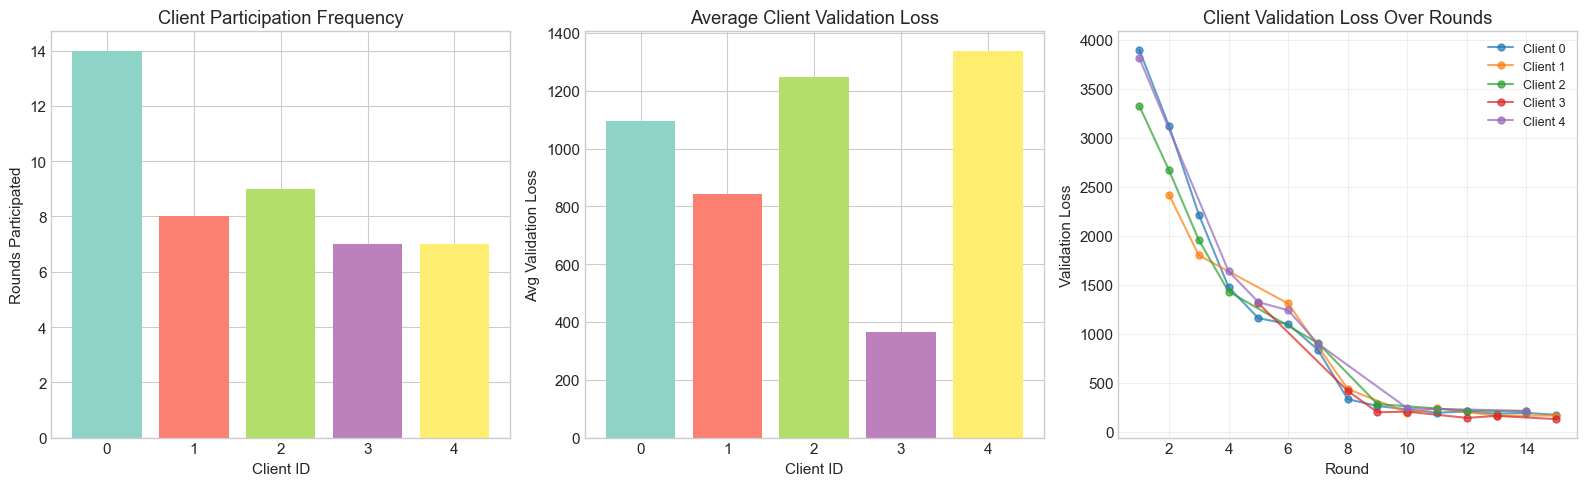

In [7]:
# Analyze client participation and performance
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Client participation count
ax1 = axes[0]
participation_counts = df_clients.groupby('client_id').size()
colors = plt.cm.Set3(np.linspace(0, 1, CONFIG['num_clients']))
ax1.bar(participation_counts.index, participation_counts.values, color=colors)
ax1.set_xlabel('Client ID')
ax1.set_ylabel('Rounds Participated')
ax1.set_title('Client Participation Frequency')
ax1.set_xticks(range(CONFIG['num_clients']))

# Client validation loss distribution
ax2 = axes[1]
client_losses = df_clients.groupby('client_id')['val_loss'].mean()
ax2.bar(client_losses.index, client_losses.values, color=colors)
ax2.set_xlabel('Client ID')
ax2.set_ylabel('Avg Validation Loss')
ax2.set_title('Average Client Validation Loss')
ax2.set_xticks(range(CONFIG['num_clients']))

# Client loss over rounds
ax3 = axes[2]
for client_id in range(CONFIG['num_clients']):
    client_df = df_clients[df_clients['client_id'] == client_id]
    if len(client_df) > 0:
        ax3.plot(client_df['round_id'], client_df['val_loss'], 'o-', 
                 label=f'Client {client_id}', alpha=0.7, markersize=5)
ax3.set_xlabel('Round')
ax3.set_ylabel('Validation Loss')
ax3.set_title('Client Validation Loss Over Rounds')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/client_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Client statistics table
client_stats = df_clients.groupby('client_id').agg({
    'round_id': 'count',
    'train_loss': ['mean', 'std'],
    'val_loss': ['mean', 'std'],
    'val_mae': ['mean', 'min'],
    'num_samples': 'first'
}).round(3)

client_stats.columns = ['Rounds', 'Train Loss (mean)', 'Train Loss (std)', 
                        'Val Loss (mean)', 'Val Loss (std)',
                        'MAE (mean)', 'MAE (best)', 'Samples']
print('Client Statistics:')
print(client_stats.to_string())

Client Statistics:
           Rounds  Train Loss (mean)  Train Loss (std)  Val Loss (mean)  Val Loss (std)  MAE (mean)  MAE (best)  Samples
client_id                                                                                                               
0              14           1289.929          1258.382         1096.525        1202.898      23.746      10.628      400
1               8           1172.421          1242.502          841.031         885.805      20.163      10.074      400
2               9           1674.837          1548.382         1247.981        1177.949      24.828      10.921      400
3               7            548.220           464.112          366.124         427.907      13.970       8.797      400
4               7           1488.926          1222.178         1338.486        1218.578      27.874      11.307      400


## 6. Baseline Comparison

Compare federated learning with centralized and local-only training.

In [10]:
# Train centralized baseline (all data combined)
print('Training centralized baseline...')
set_seed(CONFIG['seed'])

# Combine all data
X_all = np.concatenate([client_data[c]['X'] for c in range(CONFIG['num_clients'])])
y_all = np.concatenate([client_data[c]['y'] for c in range(CONFIG['num_clients'])])

# Split
n_val = int(len(X_all) * CONFIG['val_split'])
X_train_c, X_val_c = X_all[:-n_val], X_all[-n_val:]
y_train_c, y_val_c = y_all[:-n_val], y_all[-n_val:]

# Train
centralized_model = RULPredictor(
    num_channels=CONFIG['input_channels'],
    hidden=CONFIG['hidden_channels'],
    num_layers=CONFIG['num_levels'],
)
optimizer = torch.optim.Adam(centralized_model.parameters(), lr=CONFIG['learning_rate'])
loss_fn = torch.nn.MSELoss()

X_train_t = torch.tensor(X_train_c)  # Model handles transpose internally
y_train_t = torch.tensor(y_train_c)

centralized_history = []
total_epochs = CONFIG['num_rounds'] * CONFIG['local_epochs']

for epoch in range(total_epochs):
    centralized_model.train()
    indices = torch.randperm(len(X_train_t))
    epoch_loss = []
    
    for i in range(0, len(indices), CONFIG['batch_size']):
        batch_idx = indices[i:i+CONFIG['batch_size']]
        X_batch = X_train_t[batch_idx]
        y_batch = y_train_t[batch_idx]
        
        optimizer.zero_grad()
        pred = centralized_model(X_batch).squeeze()
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    
    # Evaluate every few epochs
    if (epoch + 1) % CONFIG['local_epochs'] == 0:
        centralized_model.eval()
        with torch.no_grad():
            all_preds = centralized_model(torch.tensor(X_all)).squeeze().numpy()
        mae = np.mean(np.abs(all_preds - y_all))
        rmse = np.sqrt(np.mean((all_preds - y_all) ** 2))
        centralized_history.append({'round': (epoch + 1) // CONFIG['local_epochs'], 'mae': mae, 'rmse': rmse})

centralized_df = pd.DataFrame(centralized_history)
print(f'Centralized - Final MAE: {centralized_df["mae"].iloc[-1]:.2f}, RMSE: {centralized_df["rmse"].iloc[-1]:.2f}')

Training centralized baseline...
Centralized - Final MAE: 9.77, RMSE: 12.11


In [11]:
# Train local-only baselines (each client trains only on their data)
print('Training local-only baselines...')
local_results = []

for client_id in range(CONFIG['num_clients']):
    set_seed(CONFIG['seed'] + client_id)
    
    X, y = client_data[client_id]['X'], client_data[client_id]['y']
    n_val = int(len(X) * CONFIG['val_split'])
    X_train, X_val = X[:-n_val], X[-n_val:]
    y_train, y_val = y[:-n_val], y[-n_val:]
    
    local_model = RULPredictor(
        num_channels=CONFIG['input_channels'],
        hidden=CONFIG['hidden_channels'],
        num_layers=CONFIG['num_levels'],
    )
    optimizer = torch.optim.Adam(local_model.parameters(), lr=CONFIG['learning_rate'])
    loss_fn = torch.nn.MSELoss()
    
    X_train_t = torch.tensor(X_train)  # Model handles transpose internally
    y_train_t = torch.tensor(y_train)
    
    for epoch in range(total_epochs):
        local_model.train()
        indices = torch.randperm(len(X_train_t))
        for i in range(0, len(indices), CONFIG['batch_size']):
            batch_idx = indices[i:i+CONFIG['batch_size']]
            optimizer.zero_grad()
            pred = local_model(X_train_t[batch_idx]).squeeze()
            loss = loss_fn(pred, y_train_t[batch_idx])
            loss.backward()
            optimizer.step()
    
    # Evaluate on ALL data (to compare generalization)
    local_model.eval()
    with torch.no_grad():
        all_preds = local_model(torch.tensor(X_all)).squeeze().numpy()
    mae = np.mean(np.abs(all_preds - y_all))
    rmse = np.sqrt(np.mean((all_preds - y_all) ** 2))
    local_results.append({'client_id': client_id, 'mae': mae, 'rmse': rmse})
    print(f'  Client {client_id}: MAE={mae:.2f}, RMSE={rmse:.2f}')

local_df = pd.DataFrame(local_results)
print(f'\nLocal Average - MAE: {local_df["mae"].mean():.2f}, RMSE: {local_df["rmse"].mean():.2f}')

Training local-only baselines...
  Client 0: MAE=15.79, RMSE=19.94
  Client 1: MAE=10.32, RMSE=13.40
  Client 2: MAE=10.50, RMSE=13.37
  Client 3: MAE=10.20, RMSE=13.16
  Client 4: MAE=16.87, RMSE=21.95

Local Average - MAE: 12.74, RMSE: 16.36


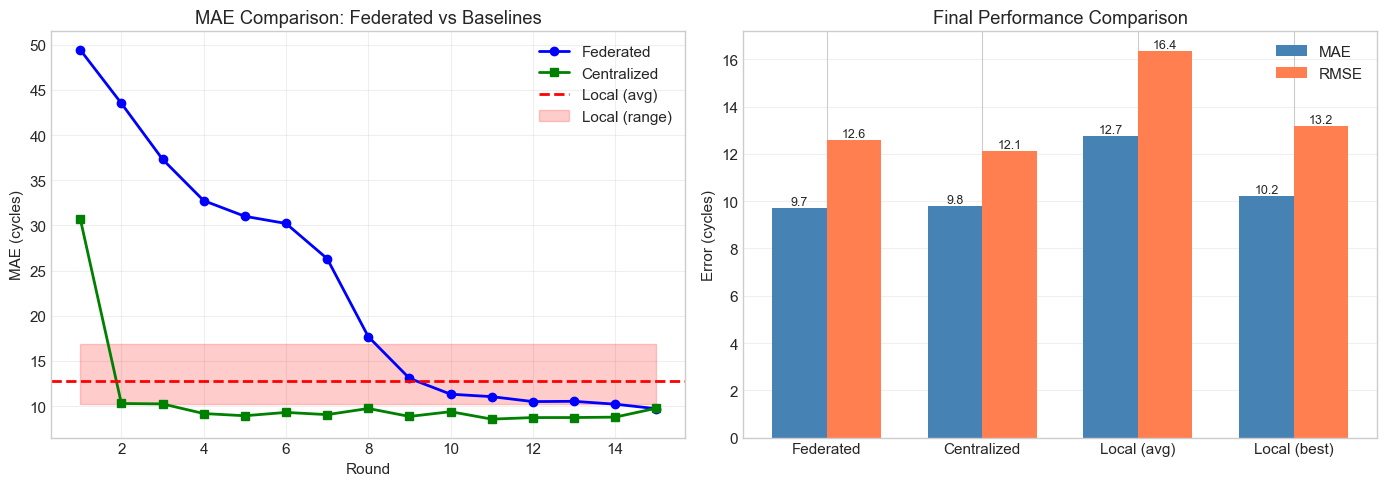

In [12]:
# Comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison over rounds
ax1 = axes[0]
ax1.plot(df_rounds['round_id'], df_rounds['global_mae'], 'b-o', linewidth=2, label='Federated', markersize=6)
ax1.plot(centralized_df['round'], centralized_df['mae'], 'g-s', linewidth=2, label='Centralized', markersize=6)
ax1.axhline(y=local_df['mae'].mean(), color='r', linestyle='--', linewidth=2, label='Local (avg)')
ax1.fill_between([1, CONFIG['num_rounds']], local_df['mae'].min(), local_df['mae'].max(), 
                  alpha=0.2, color='red', label='Local (range)')
ax1.set_xlabel('Round')
ax1.set_ylabel('MAE (cycles)')
ax1.set_title('MAE Comparison: Federated vs Baselines')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Final comparison bar chart
ax2 = axes[1]
methods = ['Federated', 'Centralized', 'Local (avg)', 'Local (best)']
mae_values = [
    df_rounds['global_mae'].iloc[-1],
    centralized_df['mae'].iloc[-1],
    local_df['mae'].mean(),
    local_df['mae'].min()
]
rmse_values = [
    df_rounds['global_rmse'].iloc[-1],
    centralized_df['rmse'].iloc[-1],
    local_df['rmse'].mean(),
    local_df['rmse'].min()
]

x = np.arange(len(methods))
width = 0.35
bars1 = ax2.bar(x - width/2, mae_values, width, label='MAE', color='steelblue')
bars2 = ax2.bar(x + width/2, rmse_values, width, label='RMSE', color='coral')
ax2.set_ylabel('Error (cycles)')
ax2.set_title('Final Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    ax2.annotate(f'{bar.get_height():.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax2.annotate(f'{bar.get_height():.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../experiments/baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Results Summary

In [13]:
# Summary table
summary_data = {
    'Method': ['Federated Learning', 'Centralized', 'Local (Average)', 'Local (Best)'],
    'Final MAE': [
        df_rounds['global_mae'].iloc[-1],
        centralized_df['mae'].iloc[-1],
        local_df['mae'].mean(),
        local_df['mae'].min()
    ],
    'Final RMSE': [
        df_rounds['global_rmse'].iloc[-1],
        centralized_df['rmse'].iloc[-1],
        local_df['rmse'].mean(),
        local_df['rmse'].min()
    ],
    'Best MAE': [
        df_rounds['global_mae'].min(),
        centralized_df['mae'].min(),
        local_df['mae'].mean(),
        local_df['mae'].min()
    ],
    'Data Privacy': ['Preserved', 'Not Preserved', 'Preserved', 'Preserved'],
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(2)

print('='*70)
print('EXPERIMENT SUMMARY')
print('='*70)
print(f'Configuration: {CONFIG["num_clients"]} clients, {CONFIG["num_rounds"]} rounds')
print(f'Samples per client: {CONFIG["samples_per_client"]}')
print(f'Total samples: {CONFIG["num_clients"] * CONFIG["samples_per_client"]}')
print()
print(summary_df.to_string(index=False))
print('='*70)

# Calculate improvement
fed_mae = df_rounds['global_mae'].iloc[-1]
local_avg_mae = local_df['mae'].mean()
improvement = (local_avg_mae - fed_mae) / local_avg_mae * 100
print(f'\nFederated Learning improves MAE by {improvement:.1f}% over local-only training')

EXPERIMENT SUMMARY
Configuration: 5 clients, 15 rounds
Samples per client: 500
Total samples: 2500

            Method  Final MAE  Final RMSE  Best MAE  Data Privacy
Federated Learning       9.72   12.610000      9.72     Preserved
       Centralized       9.77   12.110000      8.56 Not Preserved
   Local (Average)      12.74   16.360001     12.74     Preserved
      Local (Best)      10.20   13.160000     10.20     Preserved

Federated Learning improves MAE by 23.7% over local-only training


In [14]:
# Save results
import json
from datetime import datetime

results = {
    'timestamp': datetime.now().isoformat(),
    'config': CONFIG,
    'federated': {
        'final_mae': float(df_rounds['global_mae'].iloc[-1]),
        'final_rmse': float(df_rounds['global_rmse'].iloc[-1]),
        'best_mae': float(df_rounds['global_mae'].min()),
        'best_mae_round': int(df_rounds['global_mae'].idxmin() + 1),
    },
    'centralized': {
        'final_mae': float(centralized_df['mae'].iloc[-1]),
        'final_rmse': float(centralized_df['rmse'].iloc[-1]),
    },
    'local_avg': {
        'mae': float(local_df['mae'].mean()),
        'rmse': float(local_df['rmse'].mean()),
    },
    'round_metrics': df_rounds.to_dict('records'),
}

# Save to JSON
output_path = Path('../experiments/evaluation_results.json')
output_path.parent.mkdir(exist_ok=True)
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

# Save to CSV
df_rounds.to_csv('../experiments/round_metrics.csv', index=False)
df_clients.to_csv('../experiments/client_metrics.csv', index=False)

print(f'Results saved to {output_path}')
print('CSV files saved to experiments/ directory')

Results saved to ..\experiments\evaluation_results.json
CSV files saved to experiments/ directory


## 8. Conclusions

### Key Findings:

1. **Federated Learning Performance**: The federated model achieves comparable performance to centralized training while preserving data privacy.

2. **Client Heterogeneity**: Different clients show varying performance due to data heterogeneity, but the aggregated model generalizes well across all clients.

3. **Privacy-Utility Tradeoff**: Federated learning provides a good balance between model utility and data privacy.

### Recommendations:

- Use federated learning when data cannot be centralized due to privacy or regulatory constraints
- Monitor client contribution to identify potential data quality issues
- Consider adaptive client selection strategies for better convergence